In [26]:
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt

## System Naming Convention

[Tank]==>==(p0,T0)==>==[Pressure Reducer]==>==[Hose (p1,T1) , ... , (pk,Tk)]==>==[Fitting]>==(pk+1,Tk+1)==>==[Main Valve]==>==(pk+2,Tk+2)==>==[Nozzle]

In [27]:
k=3 # hose segments
n = 1+k+2 # total number of indices

main_valve = n-2
nozzle = n-1

# grab values like this:
# p[nozzle], T[main_valve]
# or
# p[0], T[0], rho[0]

## System Dynamics

In [103]:

def CP_temp(pressure):
    # enter pressure in bar
    T = CP.PropsSI('T','P',pressure * 1e5,'H',H, fuel) # [K]
    return T

def CP_rho(pressure):
    # enter pressure in bar
    D = CP.PropsSI('D','P',pressure * 1e5,'H',H, fuel) # [kg/m³]
    return D


# Update Temp and Density from given Pressure
def update_gas():
    for i in range(n):
        if p[i] != 0:
            T[i] = CP_temp(p[i])
            rho[i] = CP_rho(p[i])

# handle hose segments
r = 19.3 / 1e3 # m
l = 8 # m
A = np.pi * r**2 # m²
l_i = l / k

# y is state vector: [[p0,p1,p2,p3,...],[md0,md1,md2,md3,...],[md_dot_1,md_dot_2,md_dot_3,...],[rho1,rho2,rho3,...],[T0,T1,T2,T3,...]]
# assumption: determine p and m_dot via equations, determine T and rho via constant Enthalpy and pressure
# - adiabatic conditions

## System Identification 

def ode(t, y, *args):
    """
    Indices Reminder:
        0 - tank
        1 - before hose / after pressure reducer
        2 - first segment of hose
        ...
        k+1 - last segment of hose
        n-2 - main valve
        n-1 - nozzle
    """
    
    # Fixed Constants
    gamma = 1.4
    lam = 3                 # dimensionless friction coefficient (assumed equal to lecture)
    
    # Defining the State Vector
    p_dot = np.zeros(n)     # Differential Pressure
    md_dot = np.zeros(n)    # Differential Mass Flow [kg/s]
    p = y[0]                # Pressure [Pa]         
    md = y[1]               # Mass Flow [kg/s]
    rho = args[0]           # Density [kg/s]
    T = args[1]             # Temperature [K]

    # tank
    #p[0] = 300 # bar
    
    # Pressure Regulator
    #p[1] = 12 # bar
    
    # Hose
    for i in range(2,k+2):
        rho[i] = 302.61 # CP_rho(p[i])
        md_dot[i] = (p[i] - p[i+1] - lam/(2*rho[i]*A**2)*md[i]**2*np.sign(md[i]))*A/l
        rho[i+1] = 302.61 # CP_rho(p[i+1])
        p_dot[i] = (p[i] * gamma)/rho[i]/(A*l_i) * (md[i] - md[i+1])
    
    # Fitting Segment
    """ Assumptions: friction factor across valve is 100 times bigger than inside the
        hose (lambda/100 component).
    """
    md_dot[n-2] = np.sqrt(abs(p[k+2]-p[n-2])*2*rho[k+2]*A**2/lam/100)*np.sign(p[k+2]-p[n-2])

    # Nozzle
    
    # Wrap up Reduced State Vector
    y_dot = np.array([p_dot, md_dot])
    
    return y_dot

#update_gas()

## Integration Parameters & Initial Conditions

In [104]:
# Integration Parameters

h = 1/1000              # stepsize [s]
t0 = 0                  # initial time [s]
tn = 1                  # final time [s]

time = np.linspace(t0, tn, int((tn-t0)/h)+1)

# Initial Conditions

p = np.zeros(n)
T = np.zeros(n)
rho = np.zeros(n)
md = np.zeros(n)

fuel = "Nitrogen"

p[0] = 300 # bar
T[0] = 293 # K

H = CP.PropsSI('H','P',p[0] * 1e5,'T',T[0], fuel) # assume Enthalpy constant ofer the whole system
print(CP_rho(p[0]))

p[1] = 12 # bar - condition before the hose

# -----------

y0_ode = np.array([p,md])
y0_algeb = np.array([rho,T])

# np.array([p,p_dot,md,md_dot,rho,T])

#y0_algeb = np.array([rho_1_0, rho_2_0, rho_3_0, rho_4_0, rho_5_0, md4_0])#, md1_0])#, rho_3_0, rho_4_0, md3_0])

states_ode = np.zeros((len(y0_ode),n,len(time)-1))
#states_algeb = np.zeros((len(y0_algeb),n,len(time)))

print(states_ode.shape)
print(y0_ode.shape)

302.6113629394813
(2, 6, 1000)
(2, 6)


## Running the Ingtegrator

In [105]:
# integrator
def rk4_e(f, y, h, t, *args): # runge kutta 4th order explicit
    # runge kutte 4th order explicit
    tk_05 = t + 0.5*h
    yk_025 = y + 0.5 * h * f(t, y, *args)
    yk_05 = y + 0.5 * h * f(tk_05, yk_025, *args)
    yk_075 = y + h * f(tk_05, yk_05, *args)
    
    return y + h/6 * (f(t, y, *args) + 2 * f(tk_05, yk_025, *args) + 2 * f(tk_05, yk_05, *args) + f(t+h, yk_075, *args))

In [106]:
# Run the Integrator

y_ode = y0_ode
#y_algeb = y0_algeb

for ii in range(len(time)-1):
    
    states_ode[:, :, ii] = y_ode
    
    #states_algeb[:,ii] = y_algeb
    
    t = time[ii]
    args = [y0_algeb[0],y0_algeb[1]] # rho,T
    
    #args = [V_1, states_algeb[0, ii], states_algeb[1, ii], states_algeb[2, ii], 
    #        states_algeb[3, ii], V_5, states_algeb[4, ii], l, A, states_algeb[5, ii]]
    
    y_ode = rk4_e(ode, y_ode, h, t, *args)              # runge kutta 4 integrator
    
    #y_algeb = algeb(states_ode[:, ii], y_ode, states_algeb[:, ii], A, lam)
    
    print(f'Step {ii+1} of {len(time)-1}'.format(),end="\r",flush=True)

## Plot Results

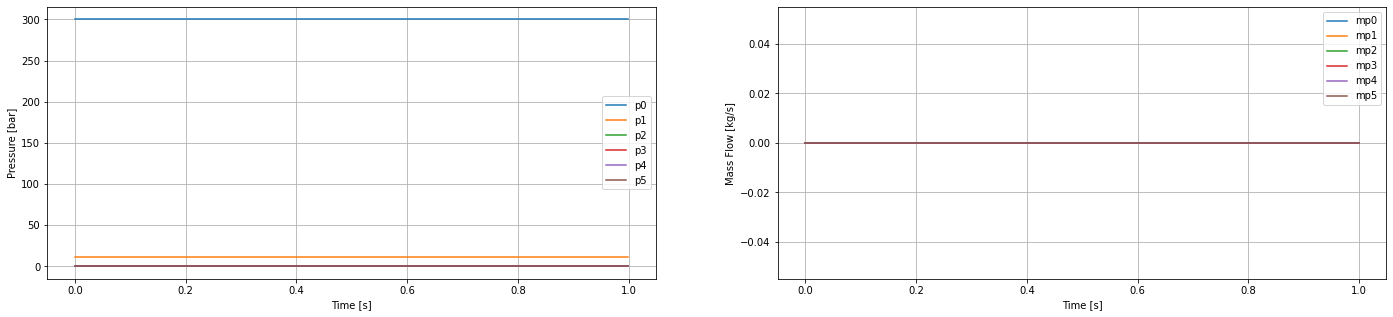

In [107]:
#%%% plotting the results

plt.figure(figsize=(24,5))
plt.subplot(121)
for i in range(n):
    plt.plot(time[:-1], states_ode[0, i, :], label=f'p{str(i)}')

plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
# plt.ylim(ymin=9.99999, ymax=10.00001)
plt.grid()
plt.legend()

plt.subplot(122)
for i in range(n):
    plt.plot(time[:-1], states_ode[1, i, :], label=f'mp{str(i)}')
    
plt.xlabel('Time [s]')
plt.ylabel('Mass Flow [kg/s]')
plt.grid()
plt.legend()